# Bootstrap

--- 

## Statement

Suppose $X_1, X_2, \ldots, X_n$ are independent and identically distributed (i.i.d.) random variables from an *unknown* distribution $F$.

Let $\theta = t(F)$ be a parameter of interest (e.g. mean, median, IQR, MSE), and define the plug-in (sample) estimator

$$
\hat{\theta}_n = t(\hat{F}_n),
$$

where $\hat{F}_n$ is the empirical distribution that puts probability $1/n$ on each observed value $X_1,\ldots,X_n$.



## Bootstrap resampling

Generate a bootstrap sample $X_1^*,\ldots,X_n^*$ by sampling **with replacement** from $\{X_1,\ldots,X_n\}$ (equivalently $X_i^* \sim \hat{F}_n$ i.i.d.). Define the bootstrap estimator

$$
\hat{\theta}_n^* = t(\hat{F}_n^*).
$$

## Bootstrap principle

The bootstrap approximates the sampling distribution of $\hat{\theta}_n$ by the conditional distribution of $\hat{\theta}_n^*$ given the data:

$$
\mathcal{L}\!\left(\hat{\theta}_n - \theta\right)
\approx
\mathcal{L}\!\left(\hat{\theta}_n^* - \hat{\theta}_n \mid X_1,\ldots,X_n\right).
$$

Equivalently, for any real numbers $a < b$,

$$
P\!\left(a \le \hat{\theta}_n - \theta \le b\right)
\approx
P^*\!\left(a \le \hat{\theta}_n^* - \hat{\theta}_n \le b\right),
$$

where $P^*(\cdot)$ denotes probability under the bootstrap resampling scheme (conditional on the observed data).


## Using the bootstrap

In practice, we draw $B$ bootstrap samples and compute
$\hat{\theta}_n^{*(1)},\ldots,\hat{\theta}_n^{*(B)}$.
These replicates approximate the sampling distribution of $\hat{\theta}_n$.

A bootstrap estimate of the standard error is

$$
\widehat{\mathrm{SE}}_{\text{boot}}(\hat{\theta}_n)
=
\sqrt{\frac{1}{B-1}\sum_{b=1}^B\left(\hat{\theta}_n^{*(b)}-\bar{\theta}^*\right)^2},
\qquad
\bar{\theta}^*=\frac{1}{B}\sum_{b=1}^B \hat{\theta}_n^{*(b)}.
$$

A bootstrap estimate of bias is

$$
\widehat{\mathrm{Bias}}_{\text{boot}}(\hat{\theta}_n)
=
\bar{\theta}^* - \hat{\theta}_n.
$$

## Bootstrap confidence intervals

Let $\hat{q}_{\alpha}$ be the empirical $\alpha$-quantile of
$\{\hat{\theta}_n^{*(b)}\}_{b=1}^B$.

- **Percentile interval:**

$$
\left[\hat{q}_{\alpha/2},\ \hat{q}_{1-\alpha/2}\right].
$$

- **Basic (pivotal) interval:**

$$
\left[2\hat{\theta}_n - \hat{q}_{1-\alpha/2},\ 2\hat{\theta}_n - \hat{q}_{\alpha/2}\right].
$$

- **Normal (Wald) interval:**

$$
\hat{\theta}_n \pm z_{1-\alpha/2}\,\widehat{\mathrm{SE}}_{\text{boot}}(\hat{\theta}_n).
$$

## Variants of the bootstrap

- **Nonparametric bootstrap:** resample from $\hat{F}_n$ (what we defined above).
- **Parametric bootstrap:** assume a parametric model $F_\psi$, estimate $\hat{\psi}$, then simulate
  $X_1^*,\ldots,X_n^* \sim F_{\hat{\psi}}$ and recompute $\hat{\theta}_n^*$.
- **Smoothed bootstrap:** resample from $\hat{F}_n$ and add small noise (useful for continuous data and density estimation).

## Notes / limitations

- The bootstrap relies on $\hat{F}_n$ being a good approximation to $F$, so accuracy typically improves with larger $n$.
- It works best for "smooth" statistics (e.g. means, regression coefficients) and can be less reliable for non-smooth ones
  (e.g. sample maximum, extreme quantiles) or heavy-tailed distributions.
- If observations are not i.i.d. (e.g. time series or clustered data), modified bootstraps are needed
  (e.g. block bootstrap, cluster bootstrap).


commonly used in random forest, some other models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# Example: skewed "unknown" data (just for illustration)
x = rng.lognormal(mean=0.0, sigma=1.0, size=200)

# Choose a statistic t(.): mean, median, IQR, etc.
def stat_mean(a): 
    return np.mean(a)

def stat_median(a):
    return np.median(a)

def stat_iqr(a):
    return np.percentile(a, 75) - np.percentile(a, 25)


In [2]:
def bootstrap_replicates(x, stat_fn, B=10_000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = len(x)
    reps = np.empty(B)
    for b in range(B):
        x_star = rng.choice(x, size=n, replace=True)  # resample with replacement
        reps[b] = stat_fn(x_star)
    return reps

def bootstrap_summary(x, stat_fn, B=10_000, alpha=0.05, rng=None):
    theta_hat = stat_fn(x)
    reps = bootstrap_replicates(x, stat_fn, B=B, rng=rng)

    se = reps.std(ddof=1)
    bias = reps.mean() - theta_hat

    # Percentile CI
    lo, hi = np.quantile(reps, [alpha/2, 1 - alpha/2])

    # Basic (pivotal) CI
    lo_basic = 2*theta_hat - hi
    hi_basic = 2*theta_hat - lo

    # Normal (Wald) CI (using bootstrap SE)
    z = 1.959963984540054  # approx qnorm(0.975)
    lo_norm = theta_hat - z*se
    hi_norm = theta_hat + z*se

    return {
        "theta_hat": theta_hat,
        "reps": reps,
        "se_boot": se,
        "bias_boot": bias,
        "ci_percentile": (lo, hi),
        "ci_basic": (lo_basic, hi_basic),
        "ci_normal": (lo_norm, hi_norm),
    }


In [3]:
out = bootstrap_summary(x, stat_iqr, B=20_000, alpha=0.05, rng=rng)

print("theta_hat:", out["theta_hat"])
print("SE_boot:  ", out["se_boot"])
print("Bias_boot:", out["bias_boot"])
print("Percentile CI:", out["ci_percentile"])
print("Basic CI:     ", out["ci_basic"])
print("Normal CI:    ", out["ci_normal"])


theta_hat: 1.1888735497593417
SE_boot:   0.14576269721999208
Bias_boot: 0.015089942647863452
Percentile CI: (0.9636686669340611, 1.4802657643773653)
Basic CI:      (0.897481335141318, 1.4140784325846223)
Normal CI:     (0.9031839129187406, 1.474563186599943)


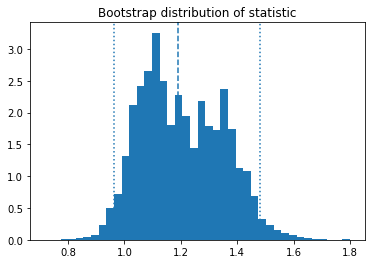

In [4]:
reps = out["reps"]
theta_hat = out["theta_hat"]
ci_lo, ci_hi = out["ci_percentile"]

plt.figure()
plt.hist(reps, bins=40, density=True)
plt.axvline(theta_hat, linestyle="--")
plt.axvline(ci_lo, linestyle=":")
plt.axvline(ci_hi, linestyle=":")
plt.title("Bootstrap distribution of statistic")
plt.show()
